In [1]:
#standard python packages
import pandas as pd
import re
import numpy as np
from datetime import datetime
import tkinter as tk
from tkinter import simpledialog, scrolledtext 
from tkinter import ttk
from PIL import Image, ImageTk
from tkinter import messagebox
import math
import os

#python files in the directory
from dal_class_1 import DAL
from class_tkinter import SiteInformationApp  
from site_information_class import SiteDataProcessor
import processing_functions
from plotting_raw_data_class_e import PlotWindow

Runs the downloader window

In [ ]:
if __name__ == "__main__":
    root = tk.Tk()
    app = SiteInformationApp(root)
    root.mainloop()
    # Access the DataFrame after the main loop
    df_spill_hours = app.df_spill_hours
    df_rainfall_raw = app.df_rainfall_global
    df_raw_sump = app.df_raw_sump_global
    df_hour_agg_flow_meter_raw = app.df_hour_agg_flow_meter_global
    #df_raw_flow_meter = app.df_raw_flow_meter_global
    start_date_downloaded = app.start_date_global
    end_date_downloaded = app.end_date_global
    site_id_selected = app.site_id


Saves the downloaded dataframes into the /raw folder

In [ ]:
# Define file paths
file_paths = {
    #"df_spill_hours": "../data/raw/site_id{site_id_selected}_{start_date_downloaded}_to_{end_date_downloaded}_df_spill_hours.xlsx",
    "df_rainfall_raw": f"../data/raw/site_id{site_id_selected}_{start_date_downloaded}_to_{end_date_downloaded}_df_rainfall_raw.xlsx",
    "df_raw_sump": f"../data/raw/site_id{site_id_selected}_{start_date_downloaded}_to_{end_date_downloaded}_df_raw_sump.xlsx",
    "df_hour_agg_flow_meter_raw": f"../data/raw/site_id{site_id_selected}_{start_date_downloaded}_to_{end_date_downloaded}_df_hour_agg_flow_meter_raw.xlsx",
    #"df_raw_flow_meter": f"../data/raw/site_id{site_id_selected}_{start_date_downloaded}_to_{end_date_downloaded}_df_raw_flow_meter.xlsx"
}

# Function to save dataframes to xlsx files
def save_dataframes(**kwargs):
    for name, df in kwargs.items():
        file_path = file_paths.get(name)
        if file_path:
            df.to_excel(file_path, index=False)
            print(f"{name} saved to {file_path}")

# Example usage:
# Assuming the dataframes are already defined and available as variables
# df_spill_hours, df_rainfall, df_raw_sump, df_hour_agg_flow_meter, df_raw_flow_meter

# Save the dataframes
save_dataframes(
    #df_spill_hours=df_spill_hours,
    df_rainfall_raw=df_rainfall_raw,
    df_raw_sump=df_raw_sump,
    df_hour_agg_flow_meter_raw=df_hour_agg_flow_meter_raw
    #df_raw_flow_meter=df_raw_flow_meter
)



Imports the downloaded data from excel workbooks - skip this if already in the environment from the DAL

In [2]:

import os
import pandas as pd

site_id_selected = 19505
start_date_downloaded = '2023-01-01'
end_date_downloaded = '2024-01-01'

file_paths = {
    #"df_spill_hours": "../data/raw/site_id{site_id_selected}_{start_date_downloaded}_to_{end_date_downloaded}_df_spill_hours.xlsx",
    "df_rainfall_raw": f"../data/raw/site_id{site_id_selected}_{start_date_downloaded}_to_{end_date_downloaded}_df_rainfall_raw.xlsx",
    "df_raw_sump": f"../data/raw/site_id{site_id_selected}_{start_date_downloaded}_to_{end_date_downloaded}_df_raw_sump.xlsx",
    "df_hour_agg_flow_meter_raw": f"../data/raw/site_id{site_id_selected}_{start_date_downloaded}_to_{end_date_downloaded}_df_hour_agg_flow_meter_raw.xlsx",
    #"df_raw_flow_meter": f"../data/raw/site_id{site_id_selected}_{start_date_downloaded}_to_{end_date_downloaded}_df_raw_flow_meter.xlsx"
}

# Function to load dataframes from xlsx files if they exist
def load_dataframes():
    dataframes = {}
    for name, file_path in file_paths.items():
        if os.path.exists(file_path):
            dataframes[name] = pd.read_excel(file_path)
            print(f"{name} loaded from {file_path}")
        else:
            dataframes[name] = None
            print(f"{file_path} does not exist. {name} not loaded.")
    return dataframes

# Load the dataframes if they exist
loaded_dataframes = load_dataframes()

# Access the loaded dataframes
#df_spill_hours = loaded_dataframes["df_spill_hours"]

df_rainfall_raw = loaded_dataframes["df_rainfall_raw"]
df_raw_sump = loaded_dataframes["df_raw_sump"]
df_hour_agg_flow_meter_raw = loaded_dataframes["df_hour_agg_flow_meter_raw"]
#df_raw_flow_meter = loaded_dataframes["df_raw_flow_meter"]


df_rainfall_raw loaded from ../data/raw/site_id19505_2023-01-01_to_2024-01-01_df_rainfall_raw.xlsx
df_raw_sump loaded from ../data/raw/site_id19505_2023-01-01_to_2024-01-01_df_raw_sump.xlsx
df_hour_agg_flow_meter_raw loaded from ../data/raw/site_id19505_2023-01-01_to_2024-01-01_df_hour_agg_flow_meter_raw.xlsx


In [3]:

def transform_flow_meter_data(df_hour_agg_flow_meter):
    # Create the 'TimeGMT' column by combining Year, Month, Day, and Hour columns
    df_hour_agg_flow_meter['TimeGMT'] = pd.to_datetime(
        df_hour_agg_flow_meter['Year'].astype(str) + '-' +
        df_hour_agg_flow_meter['Month'].astype(str) + '-' +
        df_hour_agg_flow_meter['Day'].astype(str) + ' ' +
        df_hour_agg_flow_meter['Hour'].astype(str) + ':00:00'
    )
    
    # Sort the dataframe by 'TimeGMT'
    df_hour_agg_flow_meter_filtered = df_hour_agg_flow_meter.sort_values(by="TimeGMT")
    
    # Drop unnecessary columns
    df_hour_agg_flow_meter_filtered = df_hour_agg_flow_meter_filtered.drop(columns=['stddev_EValue', 'count', 'DbAddr'])
    
    return df_hour_agg_flow_meter_filtered

df_hour_agg_flow_meter = transform_flow_meter_data(df_hour_agg_flow_meter_raw) 


In [4]:
from statsmodels.tsa.seasonal import seasonal_decompose
# Make a copy of the DataFrame
df_hour_agg_flow_meter_t = df_hour_agg_flow_meter.copy()

# Convert TimeGMT to datetime
df_hour_agg_flow_meter_t['TimeGMT'] = pd.to_datetime(df_hour_agg_flow_meter_t['TimeGMT'])

# Set TimeGMT as the index
df_hour_agg_flow_meter_t.set_index('TimeGMT', inplace=True)

# Ensure the index has a frequency set
df_hour_agg_flow_meter_t = df_hour_agg_flow_meter_t.asfreq('h')

# Check if there are enough observations
if len(df_hour_agg_flow_meter_t) < 48:
    print("Not enough data points for decomposition. Need at least 48 observations.")
else:
    # Perform time series decomposition
    result = seasonal_decompose(df_hour_agg_flow_meter_t['meanEValue'], model='additive', period=24)
    # Assuming 'data' is your time series

# Remove the seasonal component
    min_value_result_seasonal = np.min(result.seasonal)
    adjusted_result_seasonal = result.seasonal - min_value_result_seasonal
    deseasonalized = df_hour_agg_flow_meter_t['meanEValue'] - adjusted_result_seasonal
    # Extract the trend component
    #df_trend = result.trend.dropna()

# Display the first few rows of the trend component
df_trend = deseasonalized



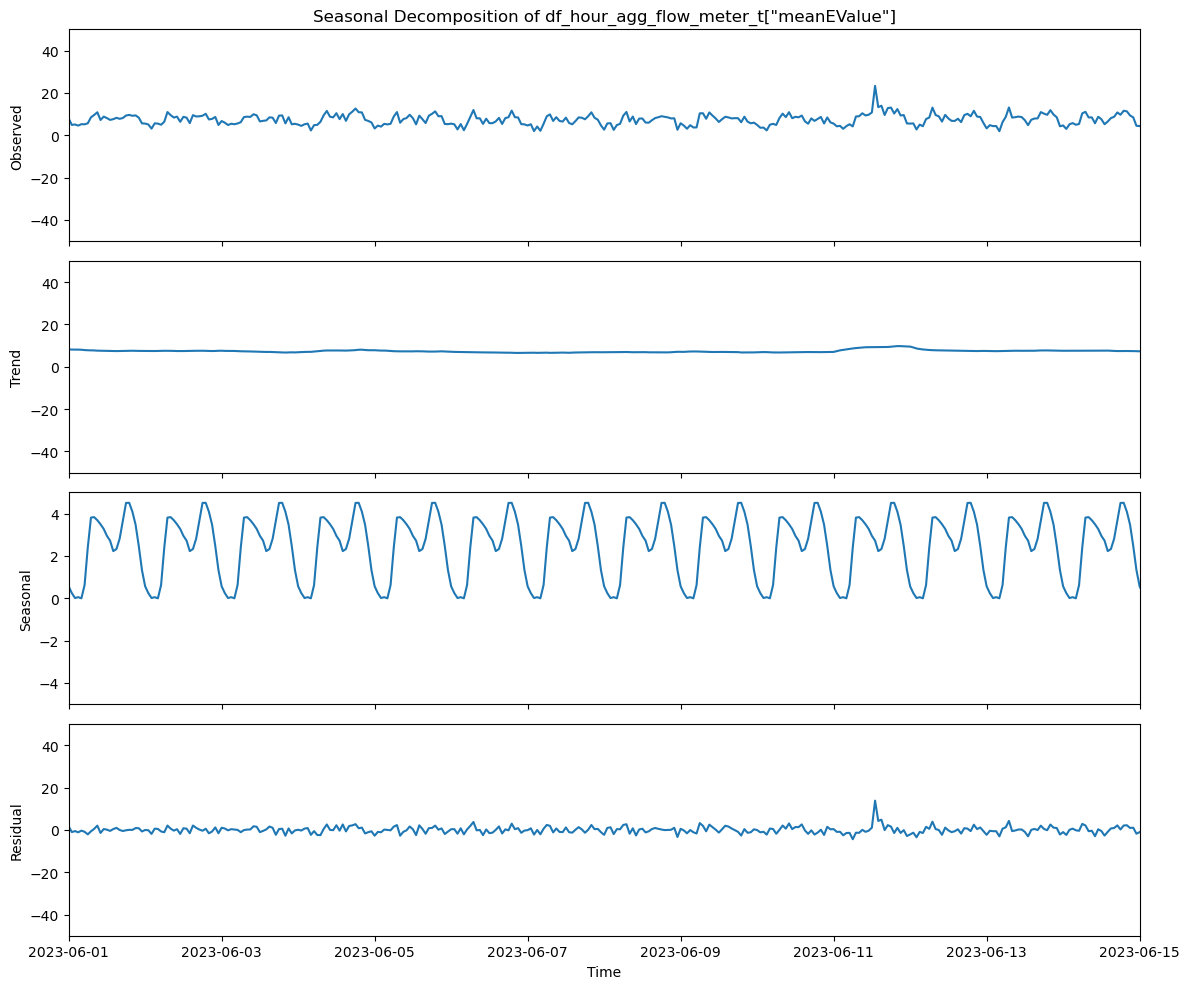

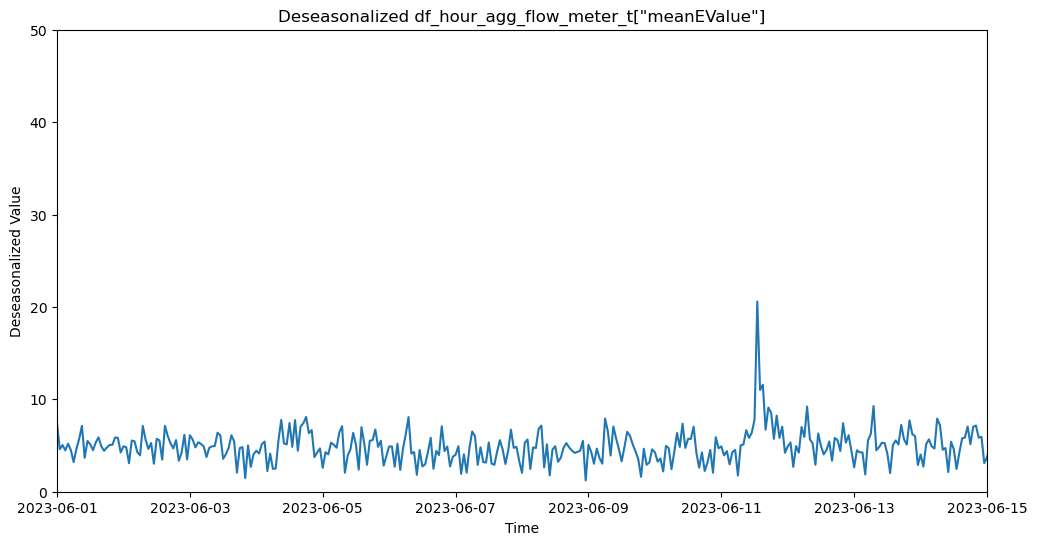

In [5]:
import matplotlib.pyplot as plt
import pandas as pd

# Define your axis limits as datetime objects
x_min = pd.to_datetime('2023-06-01')
x_max = pd.to_datetime('2023-06-15')
y_min, y_max = -50, 50  # Example value range for y-axis

# Assuming the previous code has been executed and we have the 'result' and 'deseasonalized' variables

# Plot the seasonally decomposed elements
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 10), sharex=True)

# Observed
ax1.plot(result.observed)
ax1.set_ylabel('Observed')
ax1.set_title('Seasonal Decomposition of df_hour_agg_flow_meter_t["meanEValue"]')
ax1.set_xlim([x_min, x_max])
ax1.set_ylim([y_min, y_max])

# Trend
ax2.plot(result.trend)
ax2.set_ylabel('Trend')
ax2.set_xlim([x_min, x_max])
ax2.set_ylim([y_min, y_max])

min_value_result_seasonal = np.min(result.seasonal)

adjusted_result_seasonal = result.seasonal - min_value_result_seasonal
# Seasonal
ax3.plot((adjusted_result_seasonal))
ax3.set_ylabel('Seasonal')
ax3.set_xlim([x_min, x_max])
ax3.set_ylim([-5, 5])

# Residual
ax4.plot(result.resid)
ax4.set_ylabel('Residual')
ax4.set_xlabel('Time')
ax4.set_xlim([x_min, x_max])
ax4.set_ylim([y_min, y_max])

plt.tight_layout()
plt.show()

# Plot the deseasonalized data
plt.figure(figsize=(12, 6))
plt.plot(deseasonalized)
plt.title('Deseasonalized df_hour_agg_flow_meter_t["meanEValue"]')
plt.xlabel('Time')
plt.ylabel('Deseasonalized Value')
plt.xlim([x_min, x_max])
plt.ylim([0, y_max])
plt.show()

In [6]:
# Make a copy of the DataFrame
df_hour_agg_flow_meter_t = df_hour_agg_flow_meter.copy()

# Convert TimeGMT to datetime
df_hour_agg_flow_meter_t['TimeGMT'] = pd.to_datetime(df_hour_agg_flow_meter_t['TimeGMT'])

# Set TimeGMT as the index
df_hour_agg_flow_meter_t.set_index('TimeGMT', inplace=True)

# Ensure the index has a frequency set
df_hour_agg_flow_meter_t = df_hour_agg_flow_meter_t.asfreq('h')

# Check if there are enough observations
if len(df_hour_agg_flow_meter_t) < 48:
    print("Not enough data points for decomposition. Need at least 48 observations.")
else:
    # Perform time series decomposition
    result = seasonal_decompose(df_hour_agg_flow_meter_t['meanEValue'], model='additive', period=24)

    # Create a new column 'flow_trend' in df_hour_agg_flow_meter_t
    df_hour_agg_flow_meter_t['flow_trend'] = deseasonalized

    # Fill missing values in 'flow_trend' with 'meanEValue' from the original DataFrame
    df_hour_agg_flow_meter_t['flow_trend'].fillna(df_hour_agg_flow_meter_t['meanEValue'], inplace=True)

    # Display the updated DataFrame
    print(df_hour_agg_flow_meter_t)


# Reset the index to revert 'TimeGMT' from being the index to a column
df_hour_agg_flow_meter_t.reset_index(inplace=True)



                     Hour  meanEValue  Year  Month  Day  flow_trend
TimeGMT                                                            
2023-01-01 00:00:00     0       38.30  2023      1    1   37.733344
2023-01-01 01:00:00     1       38.15  2023      1    1   37.905616
2023-01-01 02:00:00     2       38.54  2023      1    1   38.526515
2023-01-01 03:00:00     3       38.18  2023      1    1   38.126559
2023-01-01 04:00:00     4       38.71  2023      1    1   38.710000
...                   ...         ...   ...    ...  ...         ...
2024-01-01 19:00:00    19       39.67  2024      1    1   35.159411
2024-01-01 20:00:00    20       40.92  2024      1    1   36.830073
2024-01-01 21:00:00    21       39.25  2024      1    1   35.774072
2024-01-01 22:00:00    22       40.06  2024      1    1   37.588604
2024-01-01 23:00:00    23       40.18  2024      1    1   38.847506

[8784 rows x 6 columns]


C:\Users\RMCGINT\AppData\Local\Temp\ipykernel_10548\3580698913.py:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_hour_agg_flow_meter_t['flow_trend'].fillna(df_hour_agg_flow_meter_t['meanEValue'], inplace=True)


This runs the time series viewer / rtk optimizer

In [10]:
from plotting_raw_data_class_e import PlotWindow

df_sump_filtered = df_raw_sump
df_sump_filtered = df_sump_filtered.sort_values(by="TimeGMT")
df_rainfall= processing_functions.process_rainfall_data(df_rainfall_raw)
#df_hour_agg_flow_meter = processing_functions.transform_flow_meter_data(df_hour_agg_flow_meter_raw)

if __name__ == "__main__":
    import tkinter as tk
    root = tk.Tk()
    start_date_plot = '01-01-2023'
    end_date_plot = '01-01-2024'
    app2 = PlotWindow(root, start_date_plot, end_date_plot, df_raw_sump=df_sump_filtered, df_rainfall=df_rainfall, df_hour_agg_flow_meter=df_hour_agg_flow_meter_t, spill_level=100, sump_ylim=100, flow_ylim=60)
    root.mainloop()
    
    # Access RTK parameters and synthetic flow after the main loop ends
    R1, T1, K1, R2, T2, K2, df_synthetic_flow, flow_values = app2.get_rtk_parameters_and_synthetic_flow()
    print(f"Retrieved RTK Parameters Set 1: R1 = {R1}, T1 = {T1}, K1 = {K1}")
    print(f"Retrieved RTK Parameters Set 2: R2 = {R2}, T2 = {T2}, K2 = {K2}")
    print(df_synthetic_flow.head())


AttributeError: 'NoneType' object has no attribute 'empty'

In [ ]:
print(df_synthetic_flow)


In [8]:
plt.plot(df_synthetic_flow['TimeGMT'], df_synthetic_flow['SyntheticFlow'])
plt.show()

NameError: name 'df_synthetic_flow' is not defined

In [ ]:
df_hour_agg_flow_meter.head()
plt.plot(df_hour_agg_flow_meter['TimeGMT'], df_hour_agg_flow_meter['meanEValue'])
plt.show()

In [ ]:
import pandas as pd

# Assuming df_hour_agg_flow_meter and df_synthetic_flow are your DataFrames

# Merge the DataFrames on 'TimeGMT'
merged_df = pd.merge(df_hour_agg_flow_meter, df_synthetic_flow, on='TimeGMT', how='left')

# Calculate the residual flow
merged_df['residual_flow'] = merged_df['meanEValue'] - merged_df['SyntheticFlow']

# Ensure residual_flow is non-negative
merged_df['residual_flow'] = merged_df['residual_flow'].apply(lambda x: max(x, 0))

# Handle missing SyntheticFlow values by using meanEValue directly
merged_df['residual_flow'].fillna(merged_df['meanEValue'], inplace=True)

# Create the final DataFrame with 'TimeGMT' and 'residual_flow' columns
df_residual_winter_flow = merged_df[['TimeGMT', 'residual_flow']]

# Display the resulting DataFrame
print(df_residual_winter_flow.head())

In [ ]:
plt.plot(df_residual_winter_flow['TimeGMT'], df_residual_winter_flow['residual_flow'])
plt.show()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize, curve_fit
from sklearn.metrics import mean_squared_error
import warnings

# Define the function to generate synthetic flow
def generate_synthetic_flow(rainfall, R, T, K):
    synthetic_flow = np.zeros(len(rainfall))
    for i in range(len(rainfall)):
        for j in range(i):
            if 0 <= i - j < T:
                # Rising limb
                synthetic_flow[i] += R * rainfall[j] * (i - j) / T
            elif T <= i - j < T * (K + 1):
                # Falling limb
                synthetic_flow[i] += R * rainfall[j] * (T * (K + 1) - (i - j)) / (T * K)
    return synthetic_flow

# Function to fit a sine wave
def sine_wave(x, a, b, c, d):
    return a * np.sin(b * x + c) + d

# Define the weighted objective function
def weighted_objective(params, rainfall, actual_flow, months):
    R3_values = params[:12]
    T3, K3 = params[12], params[13]
    synthetic_flow = np.zeros(len(actual_flow))
    for month in range(1, 13):
        month_indices = np.where(months == month)[0]
        if len(month_indices) > 0:
            synthetic_flow[month_indices] = generate_synthetic_flow(rainfall[month_indices], R3_values[month - 1], T3, K3)
    weights = (actual_flow / np.max(actual_flow))  # Higher weights for higher flow values
    return mean_squared_error(actual_flow, synthetic_flow, sample_weight=weights)

# Ensure 'TimeGMT' is a datetime type
df_residual_winter_flow['TimeGMT'] = pd.to_datetime(df_residual_winter_flow['TimeGMT'])
df_rainfall['time_gmt_n'] = pd.to_datetime(df_rainfall['time_gmt_n'])

# Merge the DataFrames on the matching datetime columns
df_residual_winter_flow = df_residual_winter_flow.merge(df_rainfall[['time_gmt_n', 'Intensity(mm/hr)']], 
                                                        left_on='TimeGMT', right_on='time_gmt_n', how='left')

# Check if 'Intensity(mm/hr)' column exists
if 'Intensity(mm/hr)' not in df_residual_winter_flow.columns:
    raise ValueError("The 'Intensity(mm/hr)' column is missing from the DataFrame.")

# Aggregate data by day
df_residual_winter_flow['Date'] = df_residual_winter_flow['TimeGMT'].dt.date
daily_aggregates = df_residual_winter_flow.groupby('Date').agg({
    'residual_flow': 'sum',
    'Intensity(mm/hr)': 'sum'
}).reset_index()

# Extract month from Date
daily_aggregates['Month'] = pd.to_datetime(daily_aggregates['Date']).dt.month

# Initialize arrays for R3 values and synthetic flow
initial_R3_values = np.ones(12)
initial_params = np.concatenate([initial_R3_values, [1, 1]])  # Initial guess for R3, T3, K3
bounds = [(0, None)] * 12 + [(0, None), (0, None)]  # Bounds for R3, T3, K3

# Optimize the RTK parameters to fit the data
result = minimize(weighted_objective, initial_params, args=(daily_aggregates['Intensity(mm/hr)'].values, daily_aggregates['residual_flow'].values, daily_aggregates['Month'].values), 
                  method='L-BFGS-B', bounds=bounds)

# Check if optimization was successful
if result.success:
    optimized_params = result.x
    R3_values = optimized_params[:12]
    T3, K3 = optimized_params[12], optimized_params[13]
    print(f"Optimized R3 values: {R3_values}")
    print(f"Optimized T3: {T3:.2f}, K3: {K3:.2f}")
else:
    print("Optimization failed.")
    R3_values = initial_R3_values
    T3, K3 = 1, 1

# Smooth the R3 values using a single sine wave
x_data = np.arange(1, 13)
popt, _ = curve_fit(sine_wave, x_data, R3_values)
smoothed_R3_values = sine_wave(x_data, *popt)

# Calculate the new synthetic flow using the smoothed R3 values
synthetic_flow = np.zeros(len(daily_aggregates))
for month in range(1, 13):
    month_indices = np.where(daily_aggregates['Month'].values == month)[0]
    if len(month_indices) > 0:
        synthetic_flow[month_indices] = generate_synthetic_flow(daily_aggregates['Intensity(mm/hr)'].values[month_indices], smoothed_R3_values[month - 1], T3, K3)

# Add the synthetic flow to the DataFrame
daily_aggregates['synthetic_flow'] = synthetic_flow

# Plot the result
plt.plot(daily_aggregates['Date'], daily_aggregates['residual_flow'], label='Residual Flow')
plt.plot(daily_aggregates['Date'], daily_aggregates['synthetic_flow'], label='Synthetic Flow', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Flow')
plt.title('Residual Flow and Synthetic Flow')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#df_residual_winter_flow.head(10)
daily_aggregates.head(10)

In [ ]:
print(R3_values)
print(smoothed_R3_values)
print(f't values{T3}')